# Airbnb Boston Dataset Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

In [86]:
listings = pd.read_csv("data/boston/listings.csv")
reviews = pd.read_csv('data/boston/reviews.csv')
calendar = pd.read_csv('data/boston/calendar.csv')

## Part 1: Sentiment Analysis of Reviews given by user for a particular Listing

We will analyze the sentiment of the reviews which will give us an idea about the listing.
For sentiment ananlysis of the reviews we will use [VADER](https://github.com/cjhutto/vaderSentiment) , which returns a dictinary containing score indicating how Negative, Neutral or Positive the review is. It also returns an compoung score which lies between -1 and 1, -1 being most negative and 1 being most positive.

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05


In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


The comment column contains null values which needs to be removed because VADER doesn't accepts NaN values as it would make no sense to get sentiment of a NaN value. And also, since each comment(review) is unique and depends on the reviewers experience, it would not be a good idea to impute the missing values. So we will drop the rows containing missing values for comments column

In [5]:
# Dropping rows with missing values
reviews = reviews.dropna(subset = ['comments'])
reviews.shape

(68222, 6)

In [6]:
# Initializing VADER
analyzer = SentimentIntensityAnalyzer()

In [7]:
def sentiment_analyzer(analyzer, reviews):
    '''
    Performs sentiment analysis on the list of lists (containing text) using VADER
    
    Args:
        analyzer : VADER object
        reviews : column of a dataframe or list of lists
        
    Returns:
        sentiment: list containing sentiment -1, 0, 1
    '''
    sentiment = []
    
    for review in reviews:
        
        vs = analyzer.polarity_scores(review)
        _, _, _, score = vs.values()
        
        if score >= 0.05:
            sentiment.append(1)                # Positive
            
        elif score > -0.05 and score <0.05:
            sentiment.append(0)                # Neutral
            
        elif score <= -0.05:
            sentiment.append(-1)               # Negative
            
    return sentiment

In [9]:
comments = reviews['comments'].values.tolist()
reviews['sentiment'] = sentiment_analyzer(analyzer, comments)

C:\Users\Anuj\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,1
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,1
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,1
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,1
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,1


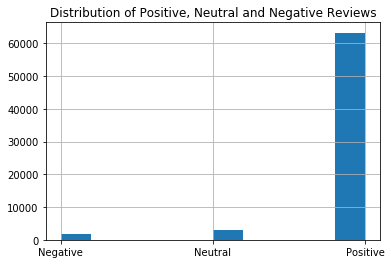

In [143]:
# Plotting distribution of Pos, Neu and Neg reviews
plt.title('Distribution of Positive, Neutral and Negative Reviews')
plt.xticks(ticks = [-1, 0, 1], labels = ['Negative', 'Neutral', 'Positive'])
reviews['sentiment'].hist()

Findings:

Most of the listings are positively rated, very few are negative. 

## Part 2: How price fluctuates? And around what time its the highest?

In [87]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


There are many null values in the price column, we can either drop the rows containing null values or impute the missing values with mean. But the price column needs some cleaning as well ie., removal of punctuation and dollar symbol and dealing with NaN values, so for simplicity we will just drop the rows.

#### 2.1 Data Cleaning

In [89]:
def clean_price(df, col):
    ''' Cleans price column by removing punctuations and dollar symbol
    
    Args: 
        dataframe that needs to be cleaned
    
    Return:
        cleaned col
    '''
    
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].apply(lambda x: float(x[1:]))
    
    return df[col]

In [90]:
# Dropping listings for whose the price is missing
calendar = calendar.dropna(subset = ['price'])

calendar['price'] = clean_price(calendar, 'price')

#### To get an an idea about the pricing of listings during the year, we extract month and day from the date column and plot it to check the fluctuation in price of the listing

In [92]:
calendar['day'] = calendar['date'].apply(lambda x: str(x).split('-')[2])
calendar['month'] = calendar['date'].apply(lambda x: str(x).split('-')[1])

In [93]:
calendar.head()

,listing_id,date,available,price,day,month
365,3075044,2017-08-22,t,65.0,22,08
366,3075044,2017-08-21,t,65.0,21,08
367,3075044,2017-08-20,t,65.0,20,08
368,3075044,2017-08-19,t,75.0,19,08
369,3075044,2017-08-18,t,75.0,18,08


In [94]:
temp = calendar.sort_values(by = ['date']).groupby(by = ['month', 'day']).mean()['price']
temp.describe()

count    365.000000
mean     201.165200
std       20.989130
min      177.023002
25%      186.764936
50%      196.100469
75%      205.207474
max      286.921977
Name: price, dtype: float64

In [95]:
temp.head()

month  day
01     01     191.555994
       02     183.823384
       03     181.801780
       04     182.311177
       05     183.256989
Name: price, dtype: float64

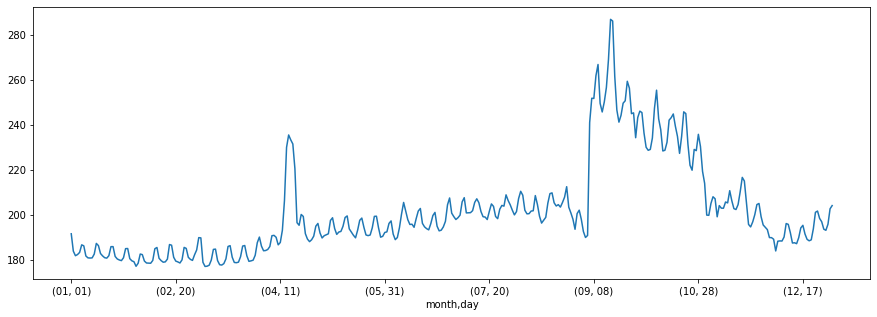

In [96]:
fig = plt.figure(figsize=(15,5))

plt.xticks()
temp.plot()

Findings:

We see an overall increasing trend in the price of the listing and few occasional spikes. The price is increasing is gradually inceasing with time and occaisonal spikes are maybe due to holidays or certains events.

## Part 3: How Price and Ratings are related?

In [97]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [98]:
import seaborn as sns

data = listings[['id','price', 'number_of_reviews', 'review_scores_rating']].dropna()
data.head()

,id,price,number_of_reviews,review_scores_rating
1,3075044,$65.00,36,94.0
2,6976,$65.00,41,98.0
3,1436513,$75.00,1,100.0
4,7651065,$79.00,29,99.0
5,12386020,$75.00,8,100.0


In [99]:
# Cleaning Price column
data['price'] = clean_price(data, 'price')
data.head()

,id,price,number_of_reviews,review_scores_rating
1,3075044,65.0,36,94.0
2,6976,65.0,41,98.0
3,1436513,75.0,1,100.0
4,7651065,79.0,29,99.0
5,12386020,75.0,8,100.0


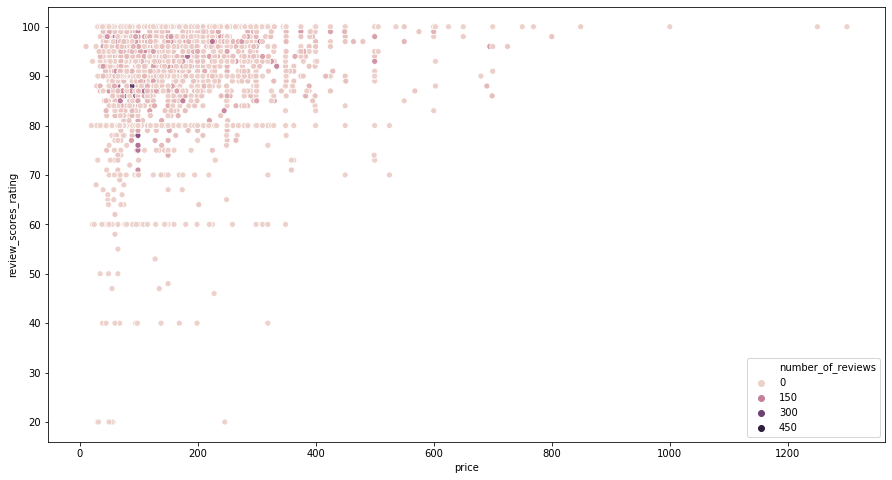

In [100]:
plt.figure(figsize = (15, 8))
sns.scatterplot(x = 'price', y = 'review_scores_rating', hue = 'number_of_reviews', data = data)

Findings:

1. Lower ratings are associated with lower prices
2. Higher prices does not means higher rating